# Statistical Machine Learning Project: Metaphor Detection

## Approach:


1.   Read data, pre-process and extract the sentence of interest
2.   Perform EDA to understand the data
3.   Create a embedding vector for analysis
4.   Experiment with statistical models such as Logistic regression and XG boost
5.   Use Bi-Directional LSTM to detect metaphors
6.   Use BERT model to create embeddings and use Bi-LSTM on the data
7.   Balance the dataset with sentences generated with GPT to balance the dataset
8.   Run the Bi-LSTM model on the new data
9.   Run the Bi-LSTM model with BERT Embeddings on the new data

Use table of contents to access different parts of the notebook









##### Importing Libraries

In [1]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

##### Reading a file

In [2]:
df_sentence = pd.read_csv('/content/train.csv')
df_sentence

,metaphorID,label_boolean,text
0,0,True,"Hey , Karen !!!! I was told that on the day of..."
1,2,False,"Hi Ladies ... my last chemo was Feb 17/09 , ra..."
2,2,False,I have just come form my consult with a lovely...
3,4,False,I also still question taking Tamox for stage 1...
4,2,False,Just checking in to say hello ladies . I had a...
...,...,...,...
1865,4,True,Hi there . I found my lump 3 weeks ago and it ...
1866,4,True,Robyn-Sorry you find yourself on this web site...
1867,0,True,I 'm happy Jule that you posted this question ...
1868,5,True,Hiya April RADs-I should probably have been he...


In [3]:
df_sentence['label_boolean'] = df_sentence['label_boolean'].astype(int)
df_sentence

,metaphorID,label_boolean,text
0,0,1,"Hey , Karen !!!! I was told that on the day of..."
1,2,0,"Hi Ladies ... my last chemo was Feb 17/09 , ra..."
2,2,0,I have just come form my consult with a lovely...
3,4,0,I also still question taking Tamox for stage 1...
4,2,0,Just checking in to say hello ladies . I had a...
...,...,...,...
1865,4,1,Hi there . I found my lump 3 weeks ago and it ...
1866,4,1,Robyn-Sorry you find yourself on this web site...
1867,0,1,I 'm happy Jule that you posted this question ...
1868,5,1,Hiya April RADs-I should probably have been he...


##1.1 Preprocessing

##### Import Spacy library and remove un-necessary punctuations and perform lemmatization

In [4]:

import spacy

# Load the spaCy English language model
nlp = spacy.load('en_core_web_sm')
def spacy_lemmatize(text):
    text=text.lower()
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\!+', '!', text)
    text = re.sub(r'\/+', '', text)
    text = re.sub(r'`', '', text)
    text = re.sub(r'-lrb-', '-', text)
    text = re.sub(r'-rrb-', '-', text)
    text = re.sub(r'\-+', '-', text)
    text = re.sub(r"I've", "i have", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"I'm", "i am", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r" - ", " . ", text)
    text = re.sub(r"i 'm", "i am", text)
    text = re.sub(r"i 've", "i have", text)
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    lemmatized_text = re.sub(r"'s\b", "s", lemmatized_text)
    return lemmatized_text


In [5]:
import re

df_sentence['lemmatized_text'] = df_sentence['text'].apply(spacy_lemmatize)
df_sentence

,metaphorID,label_boolean,text,lemmatized_text
0,0,1,"Hey , Karen !!!! I was told that on the day of...","hey , karen ! I be tell that on the day of dia..."
1,2,0,"Hi Ladies ... my last chemo was Feb 17/09 , ra...","hi lady ... my last chemo be feb 1709 , rad fi..."
2,2,0,I have just come form my consult with a lovely...,I have just come form my consult with a lovely...
3,4,0,I also still question taking Tamox for stage 1...,"I also still question take tamox for stage 1 ,..."
4,2,0,Just checking in to say hello ladies . I had a...,just check in to say hello lady . I have a lon...
...,...,...,...,...
1865,4,1,Hi there . I found my lump 3 weeks ago and it ...,hi there . I find my lump 3 week ago and it be...
1866,4,1,Robyn-Sorry you find yourself on this web site...,robyn - sorry you find yourself on this web si...
1867,0,1,I 'm happy Jule that you posted this question ...,I be happy jule that you post this question . ...
1868,5,1,Hiya April RADs-I should probably have been he...,hiya april rads - I should probably have be he...


##### Searching where the keyword of the label is and further extracting the sentence

In [6]:
important_sentences = []

for index, row in df_sentence.iterrows():
    text = ""  # Initialize an empty string

    if row['metaphorID'] == 0:
        keyword_search = 'road'
    elif row['metaphorID'] == 1:
        keyword_search = 'candle'
    elif row['metaphorID'] == 2:
        keyword_search = 'light'
    elif row['metaphorID'] == 3:
        keyword_search = 'spice'
    elif row['metaphorID'] == 4:
        keyword_search = 'ride'
    elif row['metaphorID'] == 5:
        keyword_search = 'train'
    elif row['metaphorID'] == 6:
        keyword_search = 'boat'

    for j in row['lemmatized_text'].split('.'):



        if keyword_search in j:
            if (' - ' not in j) and (' , ' not in j) and (' ; ' not in j) and (' ? ' not in j) and (' ! ' not in j):
                if keyword_search in j:
                        text = j
                        break

            elif ' , ' in j:
                for k in j.split(','):
                    if keyword_search in k:
                        text = k
                        break
            elif ' ; ' in j:
                for k in j.split(';'):
                    if keyword_search in k:
                        text = k
                        break
            elif ' ? ' in j:
                for k in j.split(' ? '):
                    if keyword_search in k:
                        text = k
                        break
            elif ' ! ' in j:
                for k in j.split(' ! '):
                    if keyword_search in k:
                        text = k
                        break
            elif ' - ' in j:
                for k in j.split(' - '):
                    if keyword_search in k:
                        text = k
                        break

    if text:
        important_sentences.append(text)

In [7]:
len(important_sentences)

1870

In [8]:
df_important_sentence = pd.DataFrame({'important_sentences': important_sentences})
df_important_sentence

,important_sentences
0,just a gliche in the road
1,be any of you have problem with feel light he...
2,light on the tonic
3,be not the rad to get ride of any stray cance...
4,light be on the tree
...,...
1865,I find my lump 3 week ago and it be be a snow...
1866,it be like a roller coaster ride at first
1867,so I will definitely be talk to my onc down t...
1868,but I join the march rads train


#### Looking for nulls

In [9]:
df_important_sentence.isna().sum()

important_sentences    0
dtype: int64

In [10]:
df_sentence['important_sentences']=df_important_sentence['important_sentences']
df_sentence

,metaphorID,label_boolean,text,lemmatized_text,important_sentences
0,0,1,"Hey , Karen !!!! I was told that on the day of...","hey , karen ! I be tell that on the day of dia...",just a gliche in the road
1,2,0,"Hi Ladies ... my last chemo was Feb 17/09 , ra...","hi lady ... my last chemo be feb 1709 , rad fi...",be any of you have problem with feel light he...
2,2,0,I have just come form my consult with a lovely...,I have just come form my consult with a lovely...,light on the tonic
3,4,0,I also still question taking Tamox for stage 1...,"I also still question take tamox for stage 1 ,...",be not the rad to get ride of any stray cance...
4,2,0,Just checking in to say hello ladies . I had a...,just check in to say hello lady . I have a lon...,light be on the tree
...,...,...,...,...,...
1865,4,1,Hi there . I found my lump 3 weeks ago and it ...,hi there . I find my lump 3 week ago and it be...,I find my lump 3 week ago and it be be a snow...
1866,4,1,Robyn-Sorry you find yourself on this web site...,robyn - sorry you find yourself on this web si...,it be like a roller coaster ride at first
1867,0,1,I 'm happy Jule that you posted this question ...,I be happy jule that you post this question . ...,so I will definitely be talk to my onc down t...
1868,5,1,Hiya April RADs-I should probably have been he...,hiya april rads - I should probably have be he...,but I join the march rads train


## 1.2 Exploratory Data Analysis

In [11]:
df_sentence['label_boolean'].value_counts()

1    1432
0     438
Name: label_boolean, dtype: int64

### Checking out the labels as per each metaphorID

In [12]:
df_sentence.groupby(['label_boolean']).count()

,metaphorID,text,lemmatized_text,important_sentences
label_boolean,,,,
0,438,438,438,438
1,1432,1432,1432,1432


In [13]:
df_sentence.groupby(['metaphorID','label_boolean']).count()

text  lemmatized_text  important_sentences
metaphorID label_boolean                                            
0          0                94               94                   94
           1               635              635                  635
1          0                11               11                   11
           1                 3                3                    3
2          0               133              133                  133
           1               352              352                  352
3          0                13               13                   13
           1                 3                3                    3
4          0               124              124                  124
           1               169              169                  169
5          0                26               26                   26
           1                71               71                   71
6          0                37               37                   37
           1               199              199                  199

#### We see there is a major class imbalance. Also, we observe some metaphor ID's have extremely small number of records with both the labels

#### Converting texts to lists

In [14]:
texts = df_sentence['important_sentences'].tolist()
labels = df_sentence["label_boolean"].tolist()

#### Checking the length of maximum length of each comment

In [15]:
max=0
len_vec=[]
for i in texts:
  len_vec.append(len(i))
  if max<len(i):
    max=len(i)
print(max)

1006


#### Plotting the length of comments in a histogram

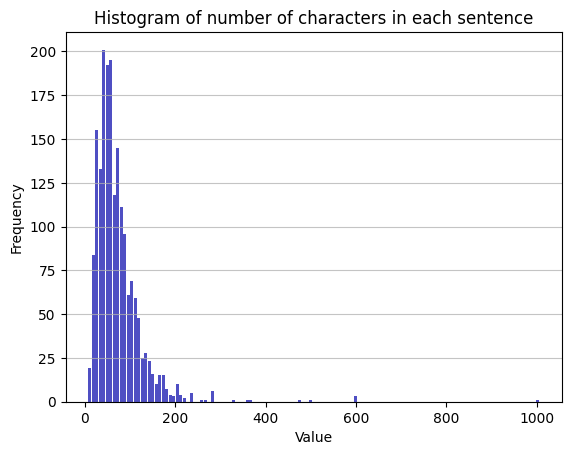

In [114]:
import matplotlib.pyplot as plt

# Replace 'your_numbers' with your list of numbers
your_numbers =len_vec

# Create a histogram
plt.hist(your_numbers, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of number of characters in each sentence')
plt.show()

#### 95% of the data seems to be by 200 characters

#### Counting the top 20 words occuring

In [17]:
from collections import Counter
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    return words

# Apply preprocessing and tokenize
df_sentence['tokenized_text'] =  df_sentence['important_sentences'].apply(preprocess_text)

# Count word frequency
word_frequencies = Counter()

# Update word frequencies for each row
for _, row in df_sentence.iterrows():
    word_frequencies.update(row['tokenized_text'])

# Convert word frequencies to a DataFrame
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])

# Sort by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

word_freq_df.head(50)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Word,Frequency
4,the,1680
6,be,1426
16,i,1373
28,and,828
1,a,773
31,to,763
5,road,736
8,of,554
10,have,509
14,light,488


#### Using stratified splitting by labels

In [18]:

from sklearn.model_selection import StratifiedShuffleSplit

# Assuming X contains your feature data and y contains the corresponding labels
# Replace 'your_label_column' with the actual name of your label column

# Example data
X = df_sentence['important_sentences'].values
y = df_sentence["label_boolean"].values


...
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)


In [19]:
unique_elements, counts = np.unique(y_test, return_counts=True)

# Print unique elements and their counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")


0: 88 times
1: 286 times


## 1.3 Experimentation with Statistical Models

#### Using logistic regression

In [20]:
import xgboost as xgb
from hyperopt import fmin, hp, tpe
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from sklearn.ensemble import RandomForestClassifier

### Using word2vec to create word embedding vector which will be used for all the statistical models

In [21]:
# Assuming X_train is a list of sentences
X_train_sentences = [str(sentence).split() for sentence in X]

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_sentences, vector_size=500, window=5, min_count=1, workers=4)

In [22]:
# Function to vectorize a sentence based on the Word2Vec model
def sentence_to_avg_vector(sentence):
    words = sentence.split()
    if len(words) == 0:
        return np.zeros(word2vec_model.vector_size)
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vectors, axis=0)

In [23]:
# Apply the function to each sentence
X_w2v = np.array([sentence_to_avg_vector(sentence) for sentence in X])

# Select labels
Y_w2v = y

# Split into train and test datasets
X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(X_w2v, Y_w2v, test_size=0.25, random_state=7)

In [24]:
from sklearn.linear_model import LogisticRegression

def lr_objective(params):
    # Map index to penalty options
    penalty_options = ['l2']
    params['penalty'] = penalty_options[params['penalty']]

    # Map index to solver options
    solver_options = ['liblinear', 'lbfgs']
    params['solver'] = solver_options[params['solver']]

    model = LogisticRegression(**params)
    model.fit(X_train_w2v, Y_train_w2v)
    y_pred = model.predict(X_test_w2v)
    accuracy = accuracy_score(Y_test_w2v, y_pred)
    return -accuracy  # Hyperopt minimizes, so we negate accuracy

In [26]:
from sklearn.metrics import accuracy_score, classification_report
# Define the search space for hyperparameters
lr_space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(1000)),
    'penalty': hp.choice('penalty', [0]),  # 'l2'
    'solver': hp.choice('solver', [0, 1]),  # 'liblinear', 'lbfgs'
    'max_iter': hp.choice('max_iter', range(100, 500)),
}

# Use Hyperopt to find the best hyperparameters
best_lr = fmin(fn=lr_objective, space=lr_space, algo=tpe.suggest, max_evals=50)

# Map index to penalty options
penalty_options = ['l2']
best_lr['penalty'] = penalty_options[best_lr['penalty']]

# Map index to solver options
solver_options = ['liblinear', 'lbfgs']
best_lr['solver'] = solver_options[best_lr['solver']]

# Print the best hyperparameters
print("Best Logistic Regression Hyperparameters:", best_lr)

# Train the final Logistic Regression model with the best hyperparameters
final_lr_model = LogisticRegression(**best_lr)
final_lr_model.fit(X_train_w2v, Y_train_w2v)
final_lr_predictions = final_lr_model.predict(X_test_w2v)

100%|██████████| 50/50 [00:12<00:00,  4.16trial/s, best loss: -0.7927350427350427]
Best Logistic Regression Hyperparameters: {'C': 986.3422278375906, 'max_iter': 111, 'penalty': 'l2', 'solver': 'lbfgs'}


In [27]:
# Evaluate the final Logistic Regression model
final_lr_accuracy = accuracy_score(Y_test_w2v, final_lr_predictions)
print("Final Logistic Regression Accuracy:", final_lr_accuracy)
print("Classification Report:")
print(classification_report(Y_test_w2v, final_lr_predictions))

Final Logistic Regression Accuracy: 0.7927350427350427
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.17      0.27       109
           1       0.80      0.98      0.88       359

    accuracy                           0.79       468
   macro avg       0.77      0.57      0.57       468
weighted avg       0.78      0.79      0.74       468



In [28]:
# Define the objective function for Hyperopt
def objective(params):
    model = xgb.XGBClassifier(**params)
    model.fit(X_train_w2v, Y_train_w2v)
    y_pred = model.predict(X_test_w2v)
    accuracy = accuracy_score(Y_test_w2v, y_pred)
    return -accuracy  # Hyperopt minimizes, so we negate accuracy

In [29]:
from sklearn.metrics import accuracy_score, classification_report
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.3),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

# Use Hyperopt to find the best hyperparameters
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)

# Print the best hyperparameters
print("Best Hyperparameters:", best)

# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(**best)
final_model.fit(X_train_w2v, Y_train_w2v)
final_predictions_XGB = final_model.predict(X_test_w2v)

# Evaluate the final model
final_accuracy = accuracy_score(Y_test_w2v, final_predictions_XGB)
print("Final XGBoost Accuracy:", final_accuracy)

100%|██████████| 100/100 [16:41<00:00, 10.01s/trial, best loss: -0.8055555555555556]
Best Hyperparameters: {'colsample_bytree': 0.3800342269281476, 'learning_rate': 0.04935081350622607, 'max_depth': 2, 'n_estimators': 166, 'subsample': 0.9844599415137907}
Final XGBoost Accuracy: 0.7799145299145299


In [30]:
print(classification_report(Y_test_w2v, final_predictions_XGB))

              precision    recall  f1-score   support

           0       0.62      0.15      0.24       109
           1       0.79      0.97      0.87       359

    accuracy                           0.78       468
   macro avg       0.70      0.56      0.55       468
weighted avg       0.75      0.78      0.72       468



### We can see that the statistical approaches does not generalise well with low precision and recall


## 1.3 Experimenting with Bi-Directional LSTM

### Building a Bi-Directional LSTM Model

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Masking, SimpleRNN, StackedRNNCells, GRU
from tensorflow.keras.optimizers import Adam # - Works


#### Initialising variables to creating word embedding vector

In [32]:
vocab_size = 3500
embedding_dim = 16
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


#### Creating a word embedding vector with just the X-train words

In [33]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [34]:
word_index = tokenizer.word_index

#### we padd sequences with 0 whoose length is less than 200 and cap the length of input to 200 sequences

In [35]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
training_padded

array([[  18,   10,    3, ...,    0,    0,    0],
       [  21,  230,   38, ...,    0,    0,    0],
       [  23,   40, 1025, ...,    0,    0,    0],
       ...,
       [   4,   73,    4, ...,    0,    0,    0],
       [  72,   88,    2, ...,    0,    0,    0],
       [  14,  189,   44, ...,    0,    0,    0]], dtype=int32)

In [37]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           56000     
                                                                 
 bidirectional (Bidirection  (None, 128)               41472     
 al)                                                             
                                                                 
 dense (Dense)               (None, 108)               13932     
                                                                 
 dense_1 (Dense)             (None, 54)                5886      
                                                                 
 dense_2 (Dense)             (None, 1)                 55        
                                                                 
Total params: 117345 (458.38 KB)
Trainable params: 117345 (458.38 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Masking
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

model_LSTM.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0015),metrics=['accuracy'])
num_epochs = 150
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

history = model_LSTM.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1,callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
47/47 [==============================] - 15s 191ms/step - loss: 0.5717 - accuracy: 0.7647 - val_loss: 0.5236 - val_accuracy: 0.7647
Epoch 2/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 5s 99ms/step - loss: 0.6314 - accuracy: 0.7908 - val_loss: 0.4144 - val_accuracy: 0.8316
Epoch 3/150
47/47 [==============================] - 3s 63ms/step - loss: 0.2560 - accuracy: 0.8991 - val_loss: 0.3804 - val_accuracy: 0.8422
Epoch 4/150
47/47 [==============================] - 4s 82ms/step - loss: 0.1549 - accuracy: 0.9405 - val_loss: 0.4460 - val_accuracy: 0.8610
Epoch 5/150
47/47 [==============================] - 2s 39ms/step - loss: 0.0645 - accuracy: 0.9779 - val_loss: 0.4847 - val_accuracy: 0.8610
Epoch 6/150
47/47 [==============================] - 2s 42ms/step - loss: 0.0359 - accuracy: 0.9893 - val_loss: 0.6598 - val_accuracy: 0.8583
Epoch 7/150
47/47 [==============================] - 1s 20ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.6232 - val_accuracy: 0.8556
Epoch 8/150
47/47 [==============================] - 2s 33ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.6960 - val_accuracy: 0.8556
Epoch 9/150
47/47 

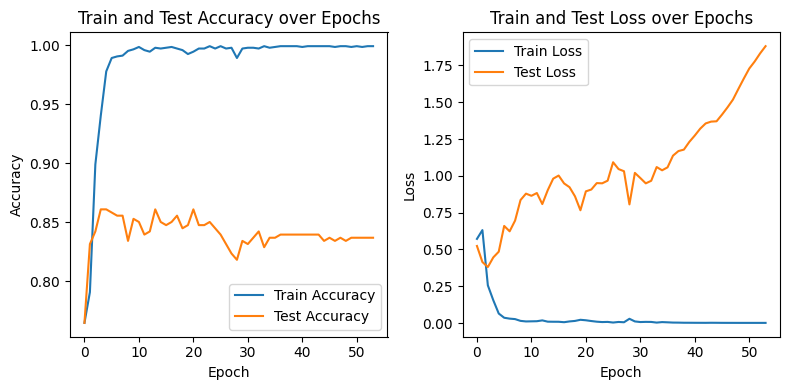

In [39]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()

# Plot training and test accuracy
plt.figure(figsize=(8, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot epoch vs loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
testing_padded.shape

(374, 200)

In [41]:
y_pred=np.round(model_LSTM.predict(testing_padded))
y_pred=y_pred.flatten()
y_pred

12/12 [==============================] - 1s 11ms/step


array([1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [42]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report( testing_labels,y_pred)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.57      0.66        88
           1       0.88      0.95      0.91       286

    accuracy                           0.86       374
   macro avg       0.83      0.76      0.79       374
weighted avg       0.85      0.86      0.85       374



##### We see the overall performance is better than the statistical models, but the recall with class 0 is low

In [43]:
## Checking with a couple of examples

In [44]:
sentence = [" i was on a train to germany", " the road to the hospital has a lot of traffic"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_LSTM.predict(padded))

1/1 [==============================] - 0s 22ms/step
[[0.8407738 ]
 [0.03981683]]


In [45]:
sentence = [" i want to train like athletes", " i was on a boat the other day"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_LSTM.predict(padded))

1/1 [==============================] - 0s 20ms/step
[[0.97100013]
 [0.71056974]]


In [46]:
sentence = [" i have burned the candle from both ends ", "  i want to spice things up with my husband"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_LSTM.predict(padded))

1/1 [==============================] - 0s 20ms/step
[[0.01660562]
 [0.00941022]]


In [47]:
sentence = ["we are on the same boat", " the road to recovery is a long one"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_LSTM.predict(padded))

1/1 [==============================] - 0s 22ms/step
[[0.96080005]
 [0.99489826]]


##### You can see due to class imbalance the model cannot identify metaphors pertaining to Candle or spice

##### Also you can see that due to class imbalance, you see some missclasifiations

### to overcome these issues, we can try to approaches:
### approach 1) Use BERT embeddings and run the model on it
### approach 2) Append the dataset with some extra records which can balance the classes and run the model

## 1.4 Experimenting with BERT Embeddings

#### Approach 1) Use BERT embeddings

In [48]:
import numpy as np
from transformers import BertTokenizer, BertModel
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import torch
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
bert_model.to(device)
embeddings = []
for sentence in X_train:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        # Move tokens to GPU
        for key in tokens:
            tokens[key] = tokens[key].to(device)

        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
embeddings = np.array(embeddings)

cuda


In [49]:
embeddings_test = []

for sentence in X_test:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
      for key in tokens:
            tokens[key] = tokens[key].to(device)
      outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embeddings_test.append(cls_embedding)

# Convert the list of embeddings to a numpy array
embeddings_test = np.array(embeddings_test)

In [50]:
embeddings.shape

(1496, 1, 768)

In [51]:
embeddings_test.shape

(374, 1, 768)

In [52]:

model_LSTM = tf.keras.Sequential([


    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), input_shape=(embeddings.shape[1], embeddings.shape[2])),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_LSTM.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128)               426496    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 108)               13932     
                                                                 
 dense_4 (Dense)             (None, 54)                5886      
                                                                 
 dense_5 (Dense)             (None, 1)                 55        
                                                                 
Total params: 446369 (1.70 MB)
Trainable params: 446369 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Masking
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
training_labels = np.array(y_train)

testing_labels = np.array(y_test)
model_LSTM.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0015),metrics=['accuracy'])
num_epochs = 150
history = model_LSTM.fit(embeddings, training_labels, epochs=num_epochs, validation_data=(embeddings_test, testing_labels), verbose=1,callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
47/47 [==============================] - 6s 33ms/step - loss: 0.4471 - accuracy: 0.7888 - val_loss: 0.3715 - val_accuracy: 0.8396
Epoch 2/150
15/47 [========>.....................] - ETA: 0s - loss: 0.3905 - accuracy: 0.8146

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - 1s 11ms/step - loss: 0.3153 - accuracy: 0.8697 - val_loss: 0.2764 - val_accuracy: 0.8824
Epoch 3/150
47/47 [==============================] - 0s 10ms/step - loss: 0.2548 - accuracy: 0.8971 - val_loss: 0.2593 - val_accuracy: 0.8877
Epoch 4/150
47/47 [==============================] - 0s 8ms/step - loss: 0.2213 - accuracy: 0.9091 - val_loss: 0.2884 - val_accuracy: 0.8850
Epoch 5/150
47/47 [==============================] - 0s 7ms/step - loss: 0.1825 - accuracy: 0.9258 - val_loss: 0.2892 - val_accuracy: 0.8717
Epoch 6/150
47/47 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9352 - val_loss: 0.4391 - val_accuracy: 0.8396
Epoch 7/150
47/47 [==============================] - 0s 7ms/step - loss: 0.1522 - accuracy: 0.9345 - val_loss: 0.3226 - val_accuracy: 0.8850
Epoch 8/150
47/47 [==============================] - 0s 7ms/step - loss: 0.0963 - accuracy: 0.9619 - val_loss: 0.3544 - val_accuracy: 0.8850
Epoch 9/150
47/47 [====

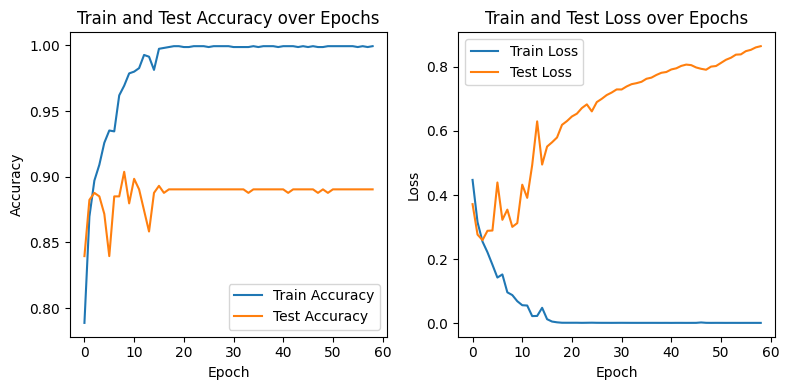

In [54]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()

# Plot training and test accuracy
plt.figure(figsize=(8, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot epoch vs loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
y_pred=np.round(model_LSTM.predict(embeddings_test))
y_pred=y_pred.flatten()
y_pred

12/12 [==============================] - 1s 3ms/step


array([1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [56]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report( testing_labels,y_pred)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79        88
           1       0.93      0.94      0.94       286

    accuracy                           0.90       374
   macro avg       0.87      0.86      0.87       374
weighted avg       0.90      0.90      0.90       374



#### we can see with the BERT embedding the same architecture has higher precision and recall with metaphors, but has the same recall as the previous model with non-metaphors.
This can be attributed to the imbalance in the class

### Testing out samples manually

In [57]:
tester=["i am on a boat", 'i am on a train to new york']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 19ms/step


array([1., 0.], dtype=float32)

In [58]:
tester=["i was on a boat ride", 'i am on a train to new york']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 19ms/step


array([0., 0.], dtype=float32)

In [59]:
tester=["i wanted to spice things up with my husband", 'i cannot handle spicy food']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 22ms/step


array([1., 0.], dtype=float32)

In [60]:
tester=["i want to train with my coach", 'a train of thoughts hit me']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 20ms/step


array([1., 1.], dtype=float32)

In [61]:
tester=[" it feels like i burned both ends of the candle", ' i lit a candle for you']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 21ms/step


array([1., 0.], dtype=float32)

### We see a significant improvement in performance in detection of metaphors with the BERT embeddings

## 1.5 Experimenting with data augmentation

#### Approach 2: Add new samples to reduce class imbalance and experiment with both embeddings



1. Added more sentences with no metaphors with 'road', 'boat', 'train', 'candle' and 'spice' in it as they were imbalanced
2. Added sentences with metaphors similar to the ones in the training set to for sentences with 'candle' and 'spice' in it. As the training data lacked sufficient sentences those keywords and the model needs to learn metaphors with these keywords


In [62]:
import pandas as pd

data = {
    'Sentences': [
        "We took a detour because of road construction on our way to the grocery store.",
        "I got stuck in traffic on the road during rush hour, and it was so frustrating.",
        "The road was so bumpy that it made the car ride uncomfortable.",
        "I love going on road trips with my friends; it's always an adventure.",
        "The road to success is often challenging, but the journey is worth it.",
        "I need to check the road conditions before heading out because of the recent snowfall.",
        "My GPS always finds the fastest route to avoid heavy traffic on the road.",
        "We had a picnic by the side of the road and enjoyed the scenic view.",
        "The road signs were confusing, and I almost missed my turn.",
        "I take the scenic route whenever possible to enjoy the beauty along the road.",
        "There was a road closure due to a marathon, and it messed up my morning commute.",
        "I always keep an emergency kit in my car, just in case I get stranded on the road.",
        "The road trip playlist made the journey more enjoyable.",
        "I had to pull over because my car was making strange noises on the road.",
        "The road ahead was foggy, and visibility was low.",
        "I love driving on winding roads; it's so much fun!",
        "I missed the exit and had to take a U-turn to get back on the right road.",
        "The road to the beach was lined with palm trees, creating a tropical vibe.",
        "I always follow the speed limit to ensure a safe journey on the road.",
        "The road was deserted, and I felt a bit uneasy driving alone at night.",
        "We hit a pothole on the road, and it gave us quite a jolt.",
        "The road trip was exhausting, but the memories made it worthwhile.",
        "I need to schedule a maintenance check for my car before hitting the road.",
        "The road was flooded due to heavy rain, so we had to take a different route.",
        "I enjoy taking the scenic route and exploring new roads in the countryside.",
        "The road to my friend's house was blocked, so I had to find an alternate way.",
        "I always keep a paper map in my glove compartment in case I lose GPS signal on the road.",
        "The road trip was filled with laughter, snacks, and good music.",
        "The road was narrow, and I had to be extra cautious while driving through the hills.",
        "I encountered a roadblock and had to wait for the construction crew to clear the debris.",
        "The road was icy, so I had to drive slowly to avoid slipping.",
        "I spotted a quaint cafe by the side of the road and decided to stop for a cup of coffee.",
        "The road to the national park was scenic, with lush greenery on both sides.",
        "I prefer taking the back roads to avoid the hustle and bustle of the main highway.",
        "The road trip was a great opportunity to bond with my family.",
          "I always keep an eye on the gas gauge to ensure I don't run out of fuel on the road.",
          "The road was steep, and the car struggled a bit to climb the hill.",
        "I enjoyed the road trip despite the occasional rain showers.",
        "I saw a beautiful sunset while driving on the coastal road.",
        "The road was blocked due to a parade, causing a traffic jam.",
        "I discovered a charming bookstore on a quaint road during my travels.",
        "The road trip was a much-needed break from the routine.",
        "I encountered a road sign indicating a detour, so I followed the alternate route.",
        "The road to the airport was clear, and I reached well ahead of time.",
        "I always pack a cooler with snacks for the road trip.",
        "The road trip with friends was filled with laughter, stories, and fun games.",
        "I spotted a deer crossing the road, so I slowed down to let it pass safely.",
        "The road was windy, making the drive through the mountains exhilarating.",
        "I had to change a flat tire on the side of the road; thankfully, I had a spare.",
        "The road to the beach was lined with colorful wildflowers.",
        "I encountered a road sign warning of deer in the area, so I drove cautiously.",
        "The road trip playlist included all our favorite songs.",
        "I took a scenic detour and discovered a charming little village off the main road.",
        "The road conditions were treacherous during the snowstorm, so I drove carefully.",
        "I enjoy the solitude of driving on quiet country roads.",
        "The road was under repair, and I had to navigate through a maze of cones.",
        "I always carry a first aid kit in my car in case of emergencies on the road.",
        "The road trip was a great opportunity to explore new places and try local cuisine.",
        "I had to pull over and ask for directions when I realized I was on the wrong road.",
        "The road to the countryside was scenic, with rolling hills and open fields.",
        "I took a shortcut, but it turned out to be a bumpy dirt road.",
        "The road trip provided a chance to admire the changing landscapes.",
        "I spotted a roadside diner and decided to stop for a quick meal during the journey.",
        "The road was blocked due to a fallen tree, so I had to find an alternate route.",
        "I always check the weather forecast before embarking on a long road trip.",
        "The road to the mountain summit was steep, but the view from the top was breathtaking.",
        "I encountered a road sign indicating a wildlife sanctuary, so I kept an eye out for animals.",
        "The road trip with my family included scenic overlooks and photo stops.",
        "I drove through a quaint village with cobblestone streets on my way to the countryside.",
        "The road was narrow, and I had to yield to oncoming traffic.",
        "I encountered a road closure due to a marathon, so I had to find an alternate route.",
        "I always carry a spare tire and tools for minor repairs on the road.",
        "The road to the beach was lined with palm trees, creating a tropical vibe.",
        "I enjoy driving on winding roads; it's so much fun!",
        "I missed the exit and had to take a U-turn to get back on the right road.",
        "The road to the mountain summit was steep, but the view from the top was breathtaking.",
        "I encountered a road sign indicating a wildlife sanctuary, so I kept an eye out for animals.",
        "The road trip with my family included scenic overlooks and photo stops.",
        "I drove through a quaint village with cobblestone streets on my way to the countryside.",
        "The road was narrow, and I had to yield to oncoming traffic.",
        "I encountered a road closure due to a marathon, so I had to find an alternate route.",
        "I always carry a spare tire and tools for minor repairs on the road.",
        "The road to the beach was lined with palm trees, creating a tropical vibe.",
        "I enjoy driving on winding roads; it's so much fun!",
        "The road stretches ahead for miles.",
    "The road is narrow and winding through the mountains.",
    "Road construction is causing delays for commuters.",
    "Drivers should obey the speed limit on the road.",
    "The road is lined with ancient trees on either side.",
    "A pedestrian is crossing the road at the crosswalk.",
    "The road is well-lit with streetlights at night.",
    "Cyclists share the road with motorists.",
    "Road maintenance is essential for a smooth driving experience.",
    "The road forks, and drivers must choose the correct lane.",
    "The road leads to a bustling city.",
    "A rural road meanders through picturesque farmland.",
    "The road is straight and flat in this part of the country.",
    "Road signs provide directions for drivers.",
    "The road narrows as it passes through the old town.",
    "Heavy rain can create puddles on the road.",
    "Drivers should be cautious on icy roads during winter.",
    "The road is flanked by open fields on both sides.",
    "Traffic lights control the flow of vehicles on the road.",
    "The road is undergoing repairs due to potholes.",
    "A bridge spans over the river, connecting two roads.",
    "The road curves gently around the serene lake.",
    "A long line of cars is stuck in traffic on the road.",
    "The road is the main artery of transportation in the region.",
    "Motorcycles zoom past on the open road.",
    "The road is bumpy in the rural countryside.",
    "A straight road is easier to navigate for new drivers.",
    "The road is deserted in the early hours of the morning.",
    "Drivers should yield to pedestrians at crosswalks on the road.",
    "A detour sign directs traffic away from the main road.",
    "The road winds through a dense forest.",
    "The road is divided into multiple lanes for different speeds.",
    "A small town is nestled along the road.",
    "The road is well-maintained with fresh asphalt.",
    "An old windmill stands by the side of the road.",
    "The road cuts through the heart of the urban landscape.",
    "A stop sign controls traffic at the intersection of two roads.",
    "The road is steep, requiring careful navigation.",
    "A cyclist is pedaling vigorously on the hilly road.",
    "The road is busy with the hustle and bustle of city life.",
    "A traffic jam has brought the road to a standstill.",
    "The road passes by a serene lake with swans.",
    "A road trip offers a sense of adventure and discovery.",
    "The road divides, leading to different neighborhoods.",
    "Drivers should watch for deer crossing the road in rural areas.",
    "The road is bordered by quaint shops and cafes.",
    "A roundabout controls traffic flow at a busy road junction.",
    "The road is surrounded by rolling hills and farmland.",
    "A highway interchange connects multiple roads.",
    "The road is part of a scenic route with breathtaking views.",
    "A motorist is changing a flat tire on the side of the road.",
    "The road is quiet in the late hours of the night.",
    "Traffic congestion is a common issue on the road.",
    "A road trip is a great way to explore the countryside.",
    "The road is well-marked with painted lines.",
    "A speed bump slows down drivers on a residential road.",
    "The road leads to a historic village.",
    "A long and straight road stretches into the distance.",
    "The road is enveloped in fog on a misty morning.",
    "A traffic officer directs vehicles at a busy road junction.",
    "The road is surrounded by tall skyscrapers in the city.",
    "A road closure requires a detour for drivers.",
    "The road passes through a vibrant urban neighborhood.",
    "A road atlas is a useful tool for long-distance travelers.",
    "The road is a lifeline for remote villages.",
    "A toll booth collects fees for using the highway.",
    "The road twists and turns through a mountain pass.",
    "A zebra crossing provides a safe passage for pedestrians on the road.",
    "The road is bordered by colorful flowers in the spring.",
    "A road trip playlist enhances the driving experience.",
    "The road is divided by a median strip.",
    "A pothole in the road poses a risk to drivers.",
    "The road is quiet during the early hours of the day.",
    "A road map helps navigate unfamiliar terrain.",
    "The road is busy with trucks transporting goods.",
    "A road closure sign indicates construction ahead.",
    "The road is flanked by residential houses.",
    "A car is parked along the side of the road.",
    "The road is well-maintained with regular repairs.",
    "A pedestrian bridge spans over the busy road.",
    "The road is illuminated by the headlights of passing cars.",
    "A road trip provides an opportunity for bonding with friends.",
    "The road is surrounded by lush greenery."
   ],
   'Label':0,
   'Metaphor_ID':0

}

df_road_no_metaphor = pd.DataFrame(data)
print(df_road_no_metaphor)


data = {
    'Sentences': [
        "I light a candle and say a prayer for my friend who is going through a difficult time.",
        "After hearing the news, I immediately lit a candle and offered my condolences in silent prayer.",
        "In times of sorrow, I light a candle to send my heartfelt condolences and prayers to those affected.",
        "I light a candle and reflect on the memories of a loved one, sending my thoughts and prayers to the grieving family.",
        "Learning about the tragedy, I lit a candle to express my condolences and prayed for strength for the affected families.",
        "In moments of sadness, I light a candle for comfort and offer my sincere prayers for healing and peace.",
        "Receiving the news of the loss, I lit a candle to honor the departed soul and prayed for solace for their loved ones.",
        "I always light a candle when offering condolences, a small gesture to accompany my heartfelt prayers.",
        "Hearing about your loss, I immediately lit a candle and whispered a prayer for you and your family.",
        "I light a candle for those facing adversity, sending my prayers for strength, resilience, and healing.",
        "In times of grief, I light a candle and extend my deepest condolences, accompanied by heartfelt prayers.",
        "I received the sad news and, in response, lit a candle to offer my condolences and send comforting prayers.",
        "I light a candle for you, my friend, offering prayers of strength, courage, and comfort during this challenging time.",
        "Learning about the difficult situation, I lit a candle and offered silent prayers for guidance and support.",
        "I always light a candle when expressing condolences, a symbol of my sincere thoughts and prayers.",
        "Hearing about your struggles, I immediately lit a candle and prayed for you, sending comfort and strength.",
        "In moments of loss, I light a candle and send my heartfelt condolences through silent prayers.",
        "I lit a candle and prayed for peace and strength to surround you during this time of sorrow.",
        "I always light a candle when offering condolences, a small ritual to accompany my thoughts and prayers.",
        "Hearing about the challenges you're facing, I lit a candle and offered my sincere condolences through prayer.",
        "I light a candle for comfort, solace, and strength, sending my prayers to those in need.",
        "In times of hardship, I light a candle to accompany my heartfelt prayers for healing and resilience.",
        "Receiving the sad news, I immediately lit a candle and prayed for you, offering my deepest condolences.",
        "I always light a candle when expressing condolences, a symbolic gesture of my thoughts and prayers.",
        "Hearing about your loss, I lit a candle and offered my condolences through silent and heartfelt prayers.",
        "I light a candle and pray for the departed soul, sending condolences and comfort to the grieving family.",
        "In times of sorrow, I light a candle and extend my deepest condolences, accompanied by heartfelt prayers.",
        "Learning about the difficult situation, I lit a candle and offered silent prayers for guidance and support.",
        "I always light a candle when expressing condolences, a symbol of my sincere thoughts and prayers.",
        "Hearing about your struggles, I immediately lit a candle and prayed for you, sending comfort and strength.",
        "In moments of loss, I light a candle and send my heartfelt condolences through silent prayers.",
        "I lit a candle and prayed for peace and strength to surround you during this time of sorrow.",
        "I always light a candle when offering condolences, a small ritual to accompany my thoughts and prayers.",
        "Hearing about the challenges you're facing, I lit a candle and offered my sincere condolences through prayer.",
        "I light a candle for comfort, solace, and strength, sending my prayers to those in need.",
        "In times of hardship, I light a candle to accompany my heartfelt prayers for healing and resilience.",
        "Receiving the sad news, I immediately lit a candle and prayed for you, offering my deepest condolences.",
        "I always light a candle when expressing condolences, a symbolic gesture of my thoughts and prayers.",
        "Hearing about your loss, I lit a candle and offered my condolences through silent and heartfelt prayers.",
        "I light a candle and pray for the departed soul, sending condolences and comfort to the grieving family."
		"I lit a candle to create a cozy atmosphere while reading my book.",
        "My friend gave me scented candles as a birthday gift, and they smell amazing.",
        "I bought a new candle holder to display my favorite candles in the living room.",
        "After a long day at work, I love to unwind by lighting a scented candle.",
        "I placed a candle on the dining table to add a touch of elegance to our dinner.",
        "During the power outage, we relied on candles to light up the room.",
        "I found a unique handmade candle at the local market, and it's now my favorite.",
		"I light a candle on my desk when I need to focus and create a calming work environment.",
        "I brought scented candles to my friend's housewarming party as a thoughtful gift.",
        "I always light a candle when I'm writing in my journal; it helps me concentrate.",
        "I have a collection of vintage candle holders that I display on my mantelpiece.",
        "I enjoy the ritual of lighting a candle before starting my meditation practice.",
        "I use scented candles with lavender fragrance to promote relaxation and better sleep.",
    ],
	'Label':0,
	'Metaphor_ID':1
}

df_no_metaphor_candle = pd.DataFrame(data)
print(df_no_metaphor_candle)



data = {
    'Sentences': [
        "Lately, I feel like I'm burning the candle at both ends, juggling work and personal life with a fiery intensity.",
        "With the project deadline looming, I find myself burning the midnight oil, the candle's flame flickering against the darkness of the night.",
        "Life has been throwing curveballs, and I'm juggling so much that it feels like I'm burning the candle at both ends.",
        "The hustle and bustle of city life have me burning the candle at both ends, leaving me yearning for a moment of tranquility.",
        "In the chaos of daily demands, it seems like I'm burning the candle from both ends, chasing after deadlines and dreams.",
        "Balancing family, work, and personal goals can feel like burning the candle at both ends, yet the glow keeps me going.",
        "The whirlwind of responsibilities has me feeling like I'm burning the candle at both ends, trying to keep up with the pace.",
        "Navigating the challenges of life sometimes feels like burning the candle at both ends, with each flame representing a different responsibility.",
        "As the weeks go by, I sense myself burning the candle at both ends, pouring energy into various aspects of life.",
        "Juggling multiple roles can be exhausting; it's like burning the candle at both ends and hoping the light doesn't fade too soon.",
        "The demands of my dual roles at work and home make it seem like I'm burning the candle at both ends, trying to keep the flames alive.",
        "In the hustle of daily life, it feels as if I'm burning the candle at both ends, chasing dreams while managing the mundane.",
        "As I tackle the challenges before me, it's like burning the candle at both ends, with each task contributing to the overall glow.",
        "The intensity of my schedule has me burning the candle at both ends, striving to find a balance between work and self-care.",
        "Life's complexities sometimes lead to burning the candle at both ends, but I find solace in the warmth of the journey.",
        "Striking a balance between career and personal life often feels like burning the candle at both ends, yet the light keeps me moving forward.",
        "In the hustle of daily commitments, it's akin to burning the candle at both ends, seeking moments of respite in the flickering glow.",
        "The dual responsibilities have me burning the candle at both ends, the flames dancing in harmony with the rhythm of life.",
        "Managing the challenges of adulthood sometimes feels like burning the candle at both ends, a delicate dance between responsibilities.",
        "The constant demands of life have me burning the candle at both ends, finding strength in the flickering flames of resilience.",
        "As I navigate the complexities of my schedule, it's like burning the candle at both ends, each task contributing to the collective glow.",
        "Juggling priorities and commitments can be overwhelming, akin to burning the candle at both ends and hoping the flame endures.",
        "The pressure to excel in multiple arenas has me burning the candle at both ends, finding strength in the luminosity of determination.",
        "Striving for a work-life balance feels like burning the candle at both ends, a delicate dance between professional aspirations and personal fulfillment.",
        "Navigating the intricacies of daily life is akin to burning the candle at both ends, with each challenge adding to the vibrant tapestry of experience.",
        "As I tackle the challenges of each day, it feels like burning the candle at both ends, the flame resilient against the winds of adversity.",
        "Juggling responsibilities is like burning the candle at both ends, a delicate balance between illumination and potential exhaustion.",
        "In the pursuit of dreams and aspirations, it often feels like burning the candle at both ends, with the flame representing unwavering determination.",
        "The ebb and flow of life's demands can be exhausting, akin to burning the candle at both ends and hoping for moments of respite.",
        "Striking a balance between career aspirations and personal well-being is like burning the candle at both ends, a dance between ambition and self-care.",
        "As I strive to meet deadlines and obligations, it feels like burning the candle at both ends, the flame resilient against the passage of time.",
        "The intricacies of daily life have me burning the candle at both ends, with the flames casting shadows that dance along the journey.",
        "Navigating the twists and turns of life feels like burning the candle at both ends, the flame a testament to resilience in the face of challenges.",
        "In the pursuit of personal and professional growth, it's like burning the candle at both ends, with each challenge contributing to the radiant glow.",
        "Juggling the responsibilities of work and personal life is akin to burning the candle at both ends, a delicate balance between dedication and self-care.",
        "The journey of self-discovery often involves burning the candle at both ends, the flames illuminating the path to personal fulfillment.",
        "As I strive for excellence in various facets of life, it feels like burning the candle at both ends, with the flames casting a warm and determined glow.",
        "The relentless pursuit of goals and aspirations has me burning the candle at both ends, finding strength in the enduring flame of ambition."
		"Facing the challenges of treatment is like holding a candle in the dark, searching for hope amidst the shadows.",
        "The journey through chemotherapy feels like walking a path illuminated by a flickering candle, each step a testament to resilience.",
        "In the midst of uncertainty, we share our experiences like passing a candle, lighting the way for others in the cancer journey.",
        "Coping with side effects often feels like balancing a delicate candle, trying to keep the flame of positivity burning.",
        "Radiation therapy can be like navigating through a maze with a candle, finding strength in the warmth of support from fellow warriors.",
        "When discussing treatment options, it's like examining a candle, exploring the different facets of hope and healing.",
        "Support groups are a bit like a circle of candles; each participant's story contributes to the collective glow of understanding.",
        "Sharing survival stories in the chat room is like passing a candle, illuminating the path for those currently in the throes of treatment.",
        "Dealing with setbacks can be akin to trying to relight a candle in the wind, the challenges threatening to extinguish our spirit.",
        "The process of healing is like tending to a fragile candle, nurturing hope and strength through the ups and downs.",
        "Expressing our fears and hopes is like lighting a candle in the heart, illuminating the emotions that often remain in the shadows.",
        "We find solace in each other's words, a bit like finding a familiar candle in the darkness of uncertainty.",
        "When discussing remission, it's like holding a candle in the wind, cautiously protecting the flame of newfound hope.",
        "Offering advice on managing symptoms is akin to sharing the light of a well-burning candle, passing on practical wisdom.",
        "Navigating the intricacies of treatment options feels like choosing the right candle, each one representing a unique path to healing.",
        "Cancer survivors are beacons of hope, like candles burning brightly, casting a warm glow on the possibilities beyond diagnosis.",
        "Supportive friendships are like candles in the dark, providing comfort and companionship on the challenging journey.",
        "Exploring complementary therapies can be like finding an additional candle, casting different hues on the canvas of healing.",
        "In the face of uncertainty, our shared stories become candles in the night, collectively dispelling the darkness of fear.",
        "When facing the unknown, discussing clinical trials is like considering a new type of candle, a potential source of light in the darkness.",
        "Managing treatment side effects is like carefully tending to a delicate candle, ensuring it continues to burn with resilience.",
        "In the chat room, words of encouragement are exchanged like candles, passing the flame of support from one person to another.",
        "Celebrating small victories feels like lighting a candle in the midst of a storm, finding joy despite the challenges.",
        "Reflecting on the journey is akin to observing a burning candle, each flicker representing moments of strength, courage, and hope.",
    ],
	'Label':1,
	'Metaphor_ID':1
}

df_candle_metaphor = pd.DataFrame(data)
print(df_candle_metaphor)





data = {
    'Sentences': [
        "Facing a chronic illness can be like losing the spice of life, as it challenges the vibrancy we once knew.",
        "Dealing with setbacks in treatment often feels like a recipe missing its spice, leaving the journey with a bit less flavor.",
        "Surviving a major surgery feels like reclaiming the spice of life, a triumphant return to normalcy.",
        "Discussing the challenges of treatment in public can be like adding an unexpected spice to the conversation, catching some off guard.",
        "Navigating the complexities of a medical diagnosis is like trying to find the right spice in a vast pantry of emotions.",
        "Sharing experiences in the chemo room is akin to swapping spice blends, each story adding a unique flavor to the collective conversation.",
        "Reflecting on the impact of illness is like realizing the absence of a beloved spice, a subtle but profound loss.",
        "The unpredictability of health can be likened to a dish missing a key spice, altering the expected flavor of life.",
        "Discussing intimate topics in a public setting can be like adding a surprising spice to the conversation, catching some by surprise.",
        "Support groups bring together various stories, each one contributing a distinct spice to the tapestry of shared experiences.",
        "Facing challenges with a sense of humor is like adding a pinch of spice to the seriousness of illness, lightening the emotional load.",
        "Exploring treatment options can be compared to selecting the right spice for a recipe, each choice influencing the overall flavor of recovery.",
        "Survivorship is akin to rediscovering the spice of life, savoring each moment with newfound appreciation.",
        "Expressing emotions openly is like adding a necessary spice to the conversation, enhancing the depth of connection in the community.",
        "The resilience of the human spirit can be likened to a secret spice, infusing strength into the challenges of the health journey.",
        "Sharing coping mechanisms is like exchanging recipes for a well-seasoned life, each tip contributing a valuable spice to the mix.",
        "Facing fears and uncertainties is like adding an unexpected spice to the journey, a bold flavor challenging the status quo.",
        "Discussing personal matters openly is like sharing the secret spice of relationships, deepening connections in unexpected ways.",
        "Supportive friendships are like the perfect spice blend, enhancing the flavors of life during challenging times.",
        "Finding joy in the small victories is akin to discovering a hidden spice, adding sweetness to the bitter moments.",
        "Facing adversity with resilience is like mastering the art of cooking with a versatile spice, adapting to various challenges.",
        "Navigating the emotional landscape of illness is like experimenting with a new spice, discovering its impact on the overall flavor of life.",
        "The unpredictability of a health journey can be like an unexpected spice, surprising us with both challenges and moments of resilience.",
        "Expressing vulnerability is like adding a necessary spice to the conversation, creating a space for authentic connection.",
        "Facing a medical diagnosis is like discovering a missing spice in the recipe of life, prompting us to adapt and find new flavors.",
        "Sharing stories of hope is like passing along a cherished spice, adding a sprinkle of encouragement to those in need.",
        "The ups and downs of treatment can be likened to the ebb and flow of a spice, influencing the overall taste of the health journey.",
        "Surviving challenges is like retaining the spice of life, a testament to resilience and the ability to overcome adversity.",
        "Expressing gratitude is like seasoning life with a positive spice, enhancing the overall flavor of the journey.",
        "Sharing laughter in the face of adversity is like adding a dash of spice to the moment, transforming the atmosphere.",
        "Discussing treatment options is like exploring a variety of spice blends, each approach offering a unique flavor to the healing process.",
        "Support groups provide a space for participants to share their unique spice, contributing to the collective richness of experiences.",
        "The journey through illness can be compared to experimenting with a new spice, adapting to its nuances and finding ways to appreciate the flavor.",
        "Navigating the unknowns of treatment is like crafting a new recipe, each decision influencing the overall spice of the healing process.",
        "Discussing life after treatment is like considering the right spice for a dish, contemplating the flavors of a renewed and resilient existence.",
        "Sharing personal victories is akin to passing along a secret spice, inspiring others to savor the sweetness of overcoming challenges.",
        "Reflecting on the journey is like savoring the blend of spices in a well-cooked dish, appreciating the unique flavor each challenge brings.",
        "Expressing empathy in the face of adversity is like adding a soothing spice to the conversation, offering comfort and understanding.",
        "Sharing advice on managing symptoms is akin to passing along a well-loved spice recipe, each tip contributing to the overall flavor of resilience."
		"I wanted to spice things up in my daily routine.",
    "Adding a new hobby to my life helped spice things up.",
    "Exploring different activities is a great way to spice things up.",
    "I decided to spice things up by trying new experiences.",
    "Spicing up my life with a positive mindset made a significant difference.",
    "Every now and then, it's important to spice things up for mental well-being.",
    "I've been trying to find ways to spice things up and make each day special.",
    "Finding joy in simple pleasures is a wonderful way to spice things up.",
    "Spicing things up with laughter is my favorite therapy.",
    "I made a conscious effort to spice things up by embracing change.",
    "Trying new flavors and cuisines is a delicious way to spice things up.",
    "Incorporating creativity into my routine has helped spice things up.",
    "To enhance my well-being, I decided to spice things up with more social interactions.",
    "I wanted to spice things up, so I started a new adventure.",
    "Spicing up my life with positivity and gratitude has been transformative.",
    "I realized the importance of spicing things up to break the monotony.",
    "Taking spontaneous trips is a fantastic way to spice things up.",
    "Spicing things up with music and dance brings so much joy.",
    "I've learned that small changes can spice things up in a big way.",
    "Adding variety to my meals has been a tasty way to spice things up.",
    "Spicing things up with a touch of spontaneity adds excitement to life.",
    "I made it a goal to spice things up by trying something new each week.",
    "Changing my perspective has been a powerful way to spice things up.",
    "Spicing up my routine with moments of mindfulness has been refreshing.",
    "I decided to spice things up by rediscovering old passions.",
    "Embracing new challenges has been an effective way to spice things up.",
    "I've been on a mission to spice things up and make life more vibrant.",
    "Spicing things up with a positive attitude has made a world of difference.",
    "Introducing variety into my daily activities has helped spice things up.",
    "I've been actively seeking opportunities to spice things up and savor life.",
    "Spicing things up by stepping out of my comfort zone has been invigorating.",
    "I realized the importance of spicing things up to keep life interesting.",
    "Trying different cuisines has been a delightful way to spice things up.",
    "I've been on a quest to spice things up and make life more flavorful.",
    "Spicing up my routine with small adventures has added excitement to my days.",
    "Introducing surprises into my routine has been a fun way to spice things up.",
    "I wanted to spice things up, so I embraced the beauty of spontaneity.",
    "Spicing up my life with moments of joy has been a transformative experience.",
    "I've been exploring new hobbies as a way to spice things up.",
    "Adding a dash of creativity to my routine has helped spice things up.",
    "Spicing things up with positive affirmations has improved my outlook on life.",
    "I made a conscious effort to spice things up and bring more joy into my days.",
    "Embracing change has been a powerful way to spice things up in my life.",
    "I've been on a mission to spice things up and make every moment count."
    ],
	'Label':1,
	'Metaphor_ID':3
}

# Create a DataFrame with a "Label" column set to 1 for metaphors
df_patient_metaphors_spice = pd.DataFrame(data)

# Display the DataFrame
print(df_patient_metaphors_spice)



data = {
    'Sentences': [
        "Turmeric is a wonderful natural spice that might interfere with chemotherapy resistance, but its effects may be limited to the gut wall.",
        "For a light meal during chemo, try chicken soup, crackers, toast, or noodle-based dishes without too much sauce or spices.",
        "Curcumin, found in turmeric, is a beneficial natural spice that may interfere with chemotherapy resistance, although its effects are mostly limited to the gut wall.",
        "Sometimes I find the ice cream in the fridge and the spices in the freezer – must be careful where I store things!",
        "When it comes to your diet during treatment, be cautious about what you eat or drink, avoiding acidic things and being mindful of your spice intake.",
        "After eating a burrito on my first day of chemo, I was a bit nervous since the salsa left my mouth a bit hot; I don't handle spices well.",
        "I was advised not to take turmeric in pill form during chemo, but incorporating it into foods in its spice form is allowed.",
        "Taking turmeric as a spice in warm water three times a day has cleared the boils for me; it's been quite effective.",
        "I prefer to put my spices in an old spice jar with big holes for easy access and usage.",
        "Planning to bake a spice cake and bring it down – hoping it lifts everyone's spirits!",
        "Consider an anti-inflammatory diet during chemo, focusing on foods like those in the Mediterranean diet, including lots of veggies, fruits, green tea, and spices such as turmeric, cinnamon, and ginger.",
        "Sticking to a diet with mostly no red meat, limited spices, and minimal alcohol has worked well for me during chemo.",
        "Chemo can sometimes magnify the taste of something, which is why mashed potatoes are a good choice – not too many spices in them.",
        "I have discovered that chemo can impact the taste of food, and sometimes avoiding overly spicy dishes is a good idea.",
        "Adding spices like cinnamon and nutmeg to my morning oatmeal has been a comforting way to start the day during treatment.",
        "Incorporating fresh herbs and spices into my meals has added flavor to my restricted diet during chemo.",
        "Finding creative ways to spice up bland foods has been a helpful strategy for maintaining a diverse diet during treatment.",
        "I've been experimenting with different spice blends to enhance the flavor of my meals without compromising my dietary restrictions.",
        "During chemo, I've learned to appreciate milder spices that don't irritate my taste buds too much.",
        "Incorporating ginger and other soothing spices into my tea has been a comforting ritual during treatment.",
        "I've been using a variety of spice-infused oils to add depth and flavor to my dishes without overwhelming my palate.",
        "Spicing up my meals with a touch of cayenne pepper or paprika has been a subtle way to add heat without causing discomfort.",
        "I've found that using a pinch of spice in my smoothies can be a creative way to make them more enjoyable during chemo.",
        "Avoiding overly spicy foods has been crucial for maintaining my digestive comfort during chemotherapy.",
        "I've developed a newfound appreciation for the subtle flavors of herbs and spices as I navigate the challenges of chemotherapy.",
        "Incorporating aromatic spices like cumin and coriander into my cooking has made the dining experience more enjoyable during treatment.",
        "Experimenting with spice rubs for grilled vegetables has been a tasty way to add variety to my chemo-friendly meals.",
        "I've learned to strike a balance with spices, opting for milder options to enhance the flavor without overwhelming my sensitive taste buds.",
        "Using spice-infused broths as a base for soups has been a flavorful and soothing choice for my chemo diet.",
        "Spicing up my snacks with a hint of chili powder or turmeric has been a satisfying way to enjoy treats within my dietary restrictions.",
        "I've found that choosing dishes with subtle spice profiles allows me to enjoy a diverse range of flavors without causing digestive discomfort.",
        "Incorporating warm spices like cinnamon and cardamom into my morning routine has added a comforting touch to my chemo days.",
        "I've discovered the joy of cooking with fresh herbs, finding that they bring a burst of flavor without relying on intense spices.",
        "Experimenting with spice blends has allowed me to tailor my meals to my taste preferences while still adhering to my dietary restrictions.",
        "Adding a dash of spice to my salads with a sprinkle of paprika or cayenne pepper has been a simple way to elevate their taste.",
        "I've learned to appreciate the subtle nuances of different spices, finding joy in discovering new ways to enhance my meals during chemo.",
        "Spicing up my morning smoothies with a hint of ginger or cinnamon has become a delightful ritual that adds flavor to my day.",
        "I've embraced the challenge of creating flavorful meals within the constraints of my chemo diet, exploring new spice combinations along the way.",
        "Choosing spice-infused dressings for my salads has been a delicious way to incorporate flavor without compromising my dietary restrictions.",
        "I've become more adventurous in my spice choices, exploring unique blends to add excitement to my chemo-friendly meals.",
        "Spicing up my desserts with a touch of cinnamon or nutmeg has been a simple yet satisfying way to enjoy sweet treats during treatment.",
        "I've found that incorporating a variety of spices into my meals allows me to enjoy a diverse and flavorful diet while undergoing chemotherapy.",
        "Experimenting with spice-infused teas has been a comforting and soothing ritual that adds warmth to my chemo days.",
        "I've learned to savor the subtle heat of spices like black pepper and cayenne, enjoying their presence without overwhelming my taste buds.",
        "Spicing up my beverages with a hint of ginger or mint has been a refreshing way to elevate my hydration routine during chemotherapy.",
        "I've discovered the joy of incorporating spices into my snacks, finding creative ways to add flavor without compromising my dietary restrictions."
    ],

	'Label':0,
	'Metaphor_ID':3
}

df_spice_no_metaphors = pd.DataFrame(data)

print(df_spice_no_metaphors)


# Sample sentences without metaphors with the main word 'train'
sentences_train = [
    "I take the train to work every day.",
    "The train station was crowded during rush hour.",
    "She missed her train and had to wait for the next one.",
    "I enjoy the scenic views when traveling by train.",
    "The train schedule is convenient for my commute.",
    "The train conductor announced the upcoming stops.",
    "I prefer to read a book while on the train.",
    "The train journey was smooth and comfortable.",
    "I always find a seat on the train in the morning.",
    "The train ticket prices have increased recently.",
    "I usually listen to music on the train.",
    "The train platform was bustling with passengers.",
    "I met a friend while waiting for the train.",
    "The train arrived at the destination on time.",
    "The train compartment was well air-conditioned.",
    "The train tracks run parallel to the highway.",
    "I like to plan my train trips in advance.",
    "The train ticket includes a reserved seat.",
    "The train conductor checked our tickets.",
    "I prefer taking the train over driving in traffic.",
    "I appreciate the efficiency of the train schedule.",
    "The train conductor announced the next stop.",
    "I enjoy the comfort of the train seats.",
    "The train journey offers a break from driving.",
    "The train tracks run parallel to a beautiful river.",
    "I enjoy the convenience of the train station's proximity to my workplace.",
    "The train ride offers a sense of continuity and routine in my daily life.",
	"He is a yoga instructor, and even after his surgery, he plans to continue teaching his regular classes.",
        "Despite my recent surgery, I am determined to get back on the basketball court and train with my teammates.",
        "After overcoming a health setback, she is eager to resume her role as a dance instructor and train her students.",
        "Despite my recent illness, I am committed to returning to the gym and training with my workout partner.",
        "Having faced a health challenge, he is motivated to get back to the soccer field and train with his team.",
        "Even after chemotherapy, she is committed to returning to the basketball court and training with her teammates.",
        "After facing a health challenge, I am determined to get back to the swimming pool and train for upcoming competitions.",
        "Despite my recent health setback, I am eager to return to the tennis court and train with my doubles partner.",
        "She is a cycling enthusiast, and even after her surgery, she plans to return to the bike trails and train for her next race.",
        "After overcoming a health challenge, he is excited to get back on the soccer field and train with his team.",
]

# Create a DataFrame with a "Label" column set to 0 for sentences without metaphors
df_no_metaphors_train = pd.DataFrame({"Sentences": sentences_train, "Label": 0,'Metaphor_ID':5})

# Display the DataFrame
print(df_no_metaphors_train)

# Sample sentences without metaphors with the main word 'boat'
sentences_boat = [
    "We took a boat trip along the river on a sunny afternoon.",
    "The boat gently rocked as we sailed across the calm lake.",
    "He steered the boat with skill through the winding canals.",
    "A small boat was anchored near the sandy beach.",
    "Our family enjoyed a relaxing day on the boat, picnicking and swimming.",
    "She waved to us from the boat as it approached the dock.",
    "The boat captain shared interesting stories about the historical landmarks we passed.",
    "The boat's motor hummed softly as we glided through the water.",
    "We rented a rowboat and explored the peaceful pond.",
    "The boat's sails billowed in the wind, propelling us forward.",
    "We watched the sunset from the deck of the boat.",
    "A group of friends rented a yacht for a weekend adventure on the open sea.",
    "The boat crew provided life jackets for everyone on board.",
    "We spotted dolphins playing in the water during our boat tour.",
    "The boat's hull sliced through the waves effortlessly.",
    "The fisherman cast his net from the side of the boat.",
    "Our boat journey took us to a secluded island with white sandy beaches.",
    "The boat's navigation system guided us safely through the harbor.",
    "We admired the city skyline while cruising on the boat at night.",
    "The boat's anchor was dropped, and we enjoyed a quiet moment on the water.",
    "The boat's engine roared to life as we began our river expedition.",
    "We set sail on a catamaran for a thrilling sailing experience.",
    "The boat trip offered breathtaking views of the coastline.",
    "Children giggled with excitement during the boat ride at the amusement park.",
    "The boat's horn echoed across the lake, signaling our departure.",
    "We explored a hidden cove accessible only by boat.",
    "The boat gently rocked us to sleep under the starry night sky.",
    "The boat's captain navigated skillfully through the narrow channel.",
    "A fleet of colorful sailboats dotted the horizon during the regatta.",
    "The boat tour provided a close-up view of the historic lighthouse.",
    "We rented a paddleboat and leisurely paddled around the pond.",
    "The boat's crewmembers assisted passengers with boarding.",
    "The boat journey through the mangrove forest was a serene nature experience.",
    "We joined a guided boat excursion to discover the rich marine life.",
    "The boat's hull gleamed in the sunlight as we cruised along the coast.",
    "We participated in a team-building activity on a rowing boat.",
    "The boat's horn signaled our arrival at the bustling harbor.",
    "We marveled at the intricate details of the traditional wooden boat.",
    "The boat captain shared interesting facts about the local marine ecosystem.",
    "Our boat adventure included a visit to a charming fishing village.",
    "The boat's wake left a mesmerizing trail on the water's surface.",
    "We rented a canoe and explored the peaceful river delta.",
    "The boat trip offered stunning views of the sunrise over the water.",
    "Children eagerly gathered at the front of the boat to spot marine life.",
    "We embarked on a catamaran cruise for a day of relaxation and snorkeling.",
    "The boat's crew provided informative commentary on the coastal landmarks.",
    "We navigated through narrow canals on a traditional gondola boat.",
    "We anchored the boat near a pristine sandy beach for a relaxing afternoon.",
    "The boat's bow pointed toward the horizon as we set sail for an island getaway.",
    "We embarked on a historic boat tour to learn about the city's maritime heritage.",
    "The boat ride provided a unique perspective of the coastal cliffs.",
    "We joined a guided boat safari to spot exotic birds along the riverbanks.",
    "The boat's captain skillfully maneuvered through a challenging sea passage.",
    "We explored a mangrove estuary on an eco-friendly electric boat.",
    "The boat's navigation system guided us through a labyrinth of canals.",
    "We anchored the boat in a tranquil lagoon surrounded by lush vegetation.",
    "The boat ride offered glimpses of marine life beneath the crystal-clear water.",
    "We set sail on a historic schooner for a nostalgic journey on the high seas.",
    "The boat's deck provided a perfect vantage point for birdwatching.",
    "We ventured on a speedboat tour, experiencing thrilling maneuvers.",
    "The boat's wake created mesmerizing patterns on the surface of the lake.",
    "We joined a boat parade to celebrate a festive maritime event.",
    "The boat's anchor was lifted, and we set out for a day of island hopping.",
    "We explored a network of underground caves accessible only by boat.",
    "The boat's crewmembers demonstrated traditional fishing techniques.",
    "We enjoyed a sunset cruise, watching the sky transform into vibrant hues.",
    "The boat's navigation lights guided us safely back to the harbor after dark.",
    "We embarked on a traditional wooden dhow boat for an Arabian Gulf excursion.",
    "The boat ride provided a front-row seat to a spectacular fireworks display.",
]

# Create a DataFrame with sentences and label them as 0 (no metaphors)
df_boat_no_metaphor = pd.DataFrame({"Sentences": sentences_boat, "Label": 0,'Metaphor_ID':6})

# Display the DataFrame
print(df_boat_no_metaphor)

new_updated_df = pd.concat([
    df_road_no_metaphor,
df_no_metaphor_candle,
df_candle_metaphor,
df_patient_metaphors_spice,
df_spice_no_metaphors,
df_no_metaphors_train,
df_boat_no_metaphor
], ignore_index=True)

# Display the concatenated DataFrame
print(new_updated_df)

import pandas as pd
import spacy
import re

# Load the spaCy English language model
nlp = spacy.load('en_core_web_sm')
def spacy_lemmatize(text):
    text=text.lower()
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\!+', '!', text)
    text = re.sub(r'\/+', '', text)
    text = re.sub(r'\-+', '-', text)
    text = re.sub(r'`', '', text)
    text = re.sub(r'-lrb-', '-', text)
    text = re.sub(r'-rrb-', '-', text)
    text = re.sub(r"I've", "i have", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"I'm", "i am", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"i 'm", "i am", text)
    text = re.sub(r"i 've", "i have", text)
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    lemmatized_text = re.sub(r"'s\b", "s", lemmatized_text)
    return lemmatized_text



new_updated_df['lemmatized_text'] = new_updated_df['Sentences'].apply(spacy_lemmatize)


important_sentences = []

for index, row in new_updated_df.iterrows():
    text = ""  # Initialize an empty string

    if row['Metaphor_ID'] == 0:
        keyword_search = 'road'
    elif row['Metaphor_ID'] == 1:
        keyword_search = 'candle'
    elif row['Metaphor_ID'] == 2:
        keyword_search = 'light'
    elif row['Metaphor_ID'] == 3:
        keyword_search = 'spice'
    elif row['Metaphor_ID'] == 4:
        keyword_search = 'ride'
    elif row['Metaphor_ID'] == 5:
        keyword_search = 'train'
    elif row['Metaphor_ID'] == 6:
        keyword_search = 'boat'

    for j in row['lemmatized_text'].split('.'):



        if keyword_search in j:
            if (' - ' not in j) and (' , ' not in j) and (' ; ' not in j) and (' ? ' not in j) and (' ! ' not in j):
                if keyword_search in j:
                        text = j
                        break

            elif ' , ' in j:
                for k in j.split(','):
                    if keyword_search in k:
                        text = k
                        break
            elif ' ; ' in j:
                for k in j.split(';'):
                    if keyword_search in k:
                        text = k
                        break
            elif ' ? ' in j:
                for k in j.split(' ? '):
                    if keyword_search in k:
                        text = k
                        break
            elif ' ! ' in j:
                for k in j.split(' ! '):
                    if keyword_search in k:
                        text = k
                        break
            elif ' - ' in j:
                for k in j.split(' - '):
                    if keyword_search in k:
                        text = k
                        break

    if text:
        important_sentences.append(text)



                                             Sentences  Label  Metaphor_ID
0    We took a detour because of road construction ...      0            0
1    I got stuck in traffic on the road during rush...      0            0
2    The road was so bumpy that it made the car rid...      0            0
3    I love going on road trips with my friends; it...      0            0
4    The road to success is often challenging, but ...      0            0
..                                                 ...    ...          ...
162  The road is well-maintained with regular repairs.      0            0
163      A pedestrian bridge spans over the busy road.      0            0
164  The road is illuminated by the headlights of p...      0            0
165  A road trip provides an opportunity for bondin...      0            0
166           The road is surrounded by lush greenery.      0            0

[167 rows x 3 columns]
                                            Sentences  Label  Metaphor_ID
0 

In [63]:
new_updated_df['data_label']=1


In [64]:
new_updated_df.groupby(['Metaphor_ID','Label']).count()

Sentences  lemmatized_text  data_label
Metaphor_ID Label                                        
0           0            167              167         167
1           0             52               52          52
            1             61               61          61
3           0             46               46          46
            1             82               82          82
5           0             37               37          37
6           0             69               69          69

In [65]:
df_sentence_print=df_sentence[['important_sentences','label_boolean','metaphorID']]
df_sentence_print['data_label']=0
df_sentence_print

<ipython-input-65-d1e3cb20e188>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentence_print['data_label']=0


,important_sentences,label_boolean,metaphorID,data_label
0,just a gliche in the road,1,0,0
1,be any of you have problem with feel light he...,0,2,0
2,light on the tonic,0,2,0
3,be not the rad to get ride of any stray cance...,0,4,0
4,light be on the tree,0,2,0
...,...,...,...,...
1865,I find my lump 3 week ago and it be be a snow...,1,4,0
1866,it be like a roller coaster ride at first,1,4,0
1867,so I will definitely be talk to my onc down t...,1,0,0
1868,but I join the march rads train,1,5,0


In [66]:
new_updated_df=new_updated_df.rename(columns={'Sentences':'important_sentences', 'Label':'label_boolean','Metaphor_ID':'metaphorID'})
new_updated_df

,important_sentences,label_boolean,metaphorID,lemmatized_text,data_label
0,We took a detour because of road construction ...,0,0,we take a detour because of road construction ...,1
1,I got stuck in traffic on the road during rush...,0,0,I get stick in traffic on the road during rush...,1
2,The road was so bumpy that it made the car rid...,0,0,the road be so bumpy that it make the car ride...,1
3,I love going on road trips with my friends; it...,0,0,I love go on road trip with my friend ; it be ...,1
4,"The road to success is often challenging, but ...",0,0,"the road to success be often challenge , but t...",1
...,...,...,...,...,...
509,The boat's crewmembers demonstrated traditiona...,0,6,the boat s crewmember demonstrate traditional ...,1
510,"We enjoyed a sunset cruise, watching the sky t...",0,6,"we enjoy a sunset cruise , watch the sky trans...",1
511,The boat's navigation lights guided us safely ...,0,6,the boat s navigation light guide we safely ba...,1
512,We embarked on a traditional wooden dhow boat ...,0,6,we embark on a traditional wooden dhow boat fo...,1


In [67]:
new_updated_df=new_updated_df[['important_sentences', 'label_boolean','metaphorID','data_label']]
concatenated_df = pd.concat([df_sentence_print,new_updated_df], ignore_index=True)



In [68]:
concatenated_df

,important_sentences,label_boolean,metaphorID,data_label
0,just a gliche in the road,1,0,0
1,be any of you have problem with feel light he...,0,2,0
2,light on the tonic,0,2,0
3,be not the rad to get ride of any stray cance...,0,4,0
4,light be on the tree,0,2,0
...,...,...,...,...
2379,The boat's crewmembers demonstrated traditiona...,0,6,1
2380,"We enjoyed a sunset cruise, watching the sky t...",0,6,1
2381,The boat's navigation lights guided us safely ...,0,6,1
2382,We embarked on a traditional wooden dhow boat ...,0,6,1


In [69]:
concatenated_df.groupby(['metaphorID','label_boolean']).count()

important_sentences  data_label
metaphorID label_boolean                                 
0          0                              261         261
           1                              635         635
1          0                               63          63
           1                               64          64
2          0                              133         133
           1                              352         352
3          0                               59          59
           1                               85          85
4          0                              124         124
           1                              169         169
5          0                               63          63
           1                               71          71
6          0                              106         106
           1                              199         199

In [70]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word.lower() for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)


# concatenated_df['important_sentences']  =important_sentences['important_sentences'].apply(pre_process_data)
concatenated_df['important_sentences_new'] = concatenated_df['important_sentences'].apply(remove_stopwords)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
concatenated_df

,important_sentences,label_boolean,metaphorID,data_label,important_sentences_new
0,just a gliche in the road,1,0,0,gliche road
1,be any of you have problem with feel light he...,0,2,0,problem feel light head ? register local run c...
2,light on the tonic,0,2,0,light tonic
3,be not the rad to get ride of any stray cance...,0,4,0,rad get ride stray cancer cell
4,light be on the tree,0,2,0,light tree
...,...,...,...,...,...
2379,The boat's crewmembers demonstrated traditiona...,0,6,1,boat 's crewmembers demonstrated traditional f...
2380,"We enjoyed a sunset cruise, watching the sky t...",0,6,1,"enjoyed sunset cruise , watching sky transform..."
2381,The boat's navigation lights guided us safely ...,0,6,1,boat 's navigation lights guided us safely bac...
2382,We embarked on a traditional wooden dhow boat ...,0,6,1,embarked traditional wooden dhow boat arabian ...


In [72]:
concatenated_df['label_boolean'].isna().sum()

0

In [73]:
test_text_df=concatenated_df[concatenated_df['data_label']==0]
test_text=test_text_df['important_sentences'].to_list()
test_text

[' just a gliche in the road ',
 ' be any of you have problem with feel light head ? I have register for our local run for the cure which take place early october and have be slowly try to get back into my joggingrunning routine ',
 ' light on the tonic ',
 ' be not the rad to get ride of any stray cancer cell',
 ' light be on the tree ',
 'the light at the end of the tunnel keep get far away ',
 ' I do find that crystal light ',
 ' be all of you glad you go down this road',
 ' anyone else be in the same boat with the endometriosis ?',
 ' but that may be the road I take ',
 ' cmf be a long road for I -lsb- 6 cycle total ; 2 week onoff ',
 'so I meet with the oncologist yesterday and it be very enlightening ',
 ' also have an episode on christmas eve of see some extremely bright light in my eye for about 20 min ',
 ' my ride begin at end of march with a suspicious mammogram ',
 ' I be glad I find your post as I be sort of in the same boat ',
 'there be light during chemo ',
 ' I have ha

In [74]:
test_labels=test_text_df['label_boolean'].to_list()
test_labels

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,


In [75]:
X_train, X_test, y_train, y_test = train_test_split(test_text, test_labels, test_size=0.20, random_state=1, stratify=test_labels)
print(len(X_train),len(y_train),len(X_test))

1496 1496 374


## 1.6 Experimenting with Bi-Directional LSTM post data augmentation

Making sure we train the model with the new data but test it with the un-augmented data

In [76]:
train_text_df=concatenated_df[concatenated_df['data_label']==1]
train_text=train_text_df['important_sentences'].to_list()

In [77]:
train_labels=train_text_df['label_boolean'].to_list()
len(train_labels),len(train_text)

(514, 514)

In [78]:
X_train=X_train+train_text
len(X_train)

2010

In [79]:
y_train=y_train+train_labels
len(y_train)

2010

In [80]:

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [81]:
from tensorflow.keras.layers import  Masking
model_LSTM2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero=True),
    Masking(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_LSTM2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 16)           56000     
                                                                 
 masking (Masking)           (None, 200, 16)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               41472     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 108)               13932     
                                                                 
 dense_7 (Dense)             (None, 54)                5886      
                                                                 
 dense_8 (Dense)             (None, 1)                 55        
                                                      

In [82]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Masking
import tensorflow as tf


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

model_LSTM2.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.000015),metrics=['accuracy'])
num_epochs = 150
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

history = model_LSTM2.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1,callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
63/63 [==============================] - 21s 165ms/step - loss: 0.6938 - accuracy: 0.4388 - val_loss: 0.6919 - val_accuracy: 0.7594
Epoch 2/150
 2/63 [..............................] - ETA: 7s - loss: 0.6919 - accuracy: 0.6875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 4s 62ms/step - loss: 0.6913 - accuracy: 0.6413 - val_loss: 0.6878 - val_accuracy: 0.7647
Epoch 3/150
63/63 [==============================] - 2s 38ms/step - loss: 0.6890 - accuracy: 0.6413 - val_loss: 0.6830 - val_accuracy: 0.7647
Epoch 4/150
63/63 [==============================] - 2s 35ms/step - loss: 0.6863 - accuracy: 0.6413 - val_loss: 0.6775 - val_accuracy: 0.7647
Epoch 5/150
63/63 [==============================] - 3s 53ms/step - loss: 0.6829 - accuracy: 0.6413 - val_loss: 0.6704 - val_accuracy: 0.7647
Epoch 6/150
63/63 [==============================] - 2s 29ms/step - loss: 0.6787 - accuracy: 0.6413 - val_loss: 0.6607 - val_accuracy: 0.7647
Epoch 7/150
63/63 [==============================] - 1s 23ms/step - loss: 0.6732 - accuracy: 0.6413 - val_loss: 0.6463 - val_accuracy: 0.7647
Epoch 8/150
63/63 [==============================] - 2s 30ms/step - loss: 0.6658 - accuracy: 0.6413 - val_loss: 0.6258 - val_accuracy: 0.7647
Epoch 9/150
63/63 

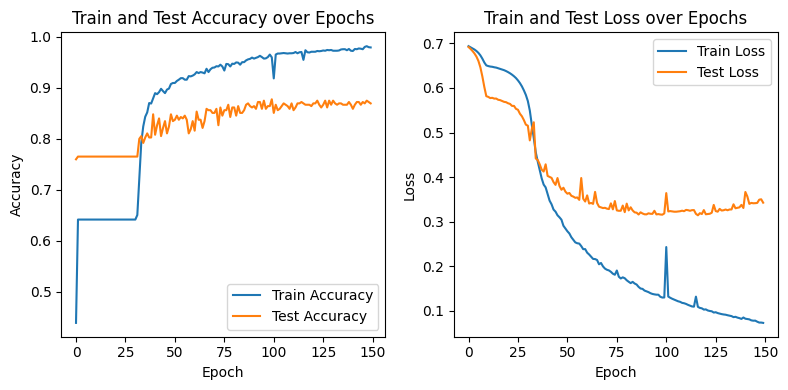

In [83]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()

# Plot training and test accuracy
plt.figure(figsize=(8, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot epoch vs loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [84]:
y_pred=np.round(model_LSTM2.predict(testing_padded))
y_pred=y_pred.flatten()
y_pred

12/12 [==============================] - 2s 13ms/step


array([1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [85]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report( testing_labels,y_pred)

# Print the classification report
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74        88
           1       0.92      0.92      0.92       286

    accuracy                           0.88       374
   macro avg       0.83      0.83      0.83       374
weighted avg       0.88      0.88      0.88       374



#### we see the recall gets better and so does precision with this data augmentation technique

## 1.7 Experimenting with BERT Embeddings with Bi-directional LSTM on augmented data

In [86]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
bert_model.to(device)
embeddings = []
for sentence in X_train:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        # Move tokens to GPU
        for key in tokens:
            tokens[key] = tokens[key].to(device)

        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
embeddings = np.array(embeddings)


embeddings_test = []

for sentence in X_test:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
      for key in tokens:
            tokens[key] = tokens[key].to(device)
      outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embeddings_test.append(cls_embedding)

# Convert the list of embeddings to a numpy array
embeddings_test = np.array(embeddings_test)

cuda


In [102]:

model_LSTM = tf.keras.Sequential([


    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64), input_shape=(embeddings.shape[1], embeddings.shape[2])),
    tf.keras.layers.Dense(216, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(54, activation='relu'),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 128)               426496    
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 216)               27864     
                                                                 
 dropout_2 (Dropout)         (None, 216)               0         
                                                                 
 dense_21 (Dense)            (None, 108)               23436     
                                                                 
 dense_22 (Dense)            (None, 108)               11772     
                                                                 
 dropout_3 (Dropout)         (None, 108)               0         
                                                      

In [104]:
# Define model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
training_labels = np.array(y_train)

testing_labels = np.array(y_test)
model_LSTM.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.000005),metrics=['accuracy'])
num_epochs = 350
history = model_LSTM.fit(embeddings, training_labels, epochs=num_epochs, validation_data=(embeddings_test, testing_labels), verbose=1,callbacks=[early_stopping, model_checkpoint])


Epoch 1/350
63/63 [==============================] - 7s 22ms/step - loss: 0.6759 - accuracy: 0.6413 - val_loss: 0.6568 - val_accuracy: 0.7647
Epoch 2/350
63/63 [==============================] - 0s 8ms/step - loss: 0.6706 - accuracy: 0.6413 - val_loss: 0.6459 - val_accuracy: 0.7647
Epoch 3/350
63/63 [==============================] - 0s 8ms/step - loss: 0.6646 - accuracy: 0.6413 - val_loss: 0.6354 - val_accuracy: 0.7647
Epoch 4/350
63/63 [==============================] - 0s 8ms/step - loss: 0.6578 - accuracy: 0.6413 - val_loss: 0.6244 - val_accuracy: 0.7647
Epoch 5/350
63/63 [==============================] - 0s 8ms/step - loss: 0.6519 - accuracy: 0.6413 - val_loss: 0.6142 - val_accuracy: 0.7647
Epoch 6/350
63/63 [==============================] - 0s 8ms/step - loss: 0.6443 - accuracy: 0.6413 - val_loss: 0.6022 - val_accuracy: 0.7647
Epoch 7/350
63/63 [==============================] - 1s 11ms/step - loss: 0.6371 - accuracy: 0.6413 - val_loss: 0.5910 - val_accuracy: 0.7647
Epoch 8/350

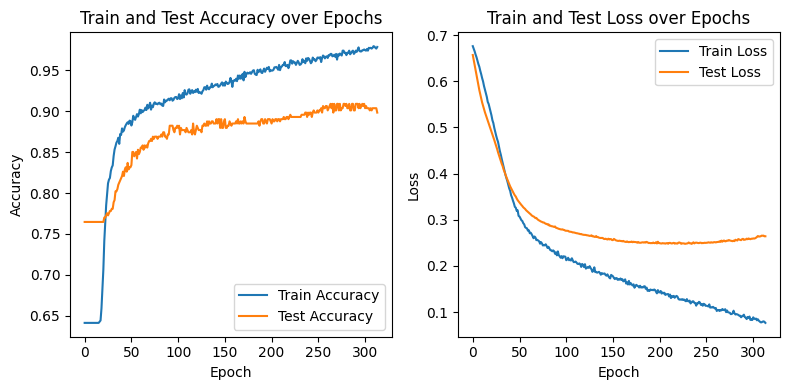

In [105]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()

# Plot training and test accuracy
plt.figure(figsize=(8, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot epoch vs loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [106]:

y_pred=np.round(model_LSTM.predict(embeddings_test))
y_pred=y_pred.flatten()
y_pred

12/12 [==============================] - 1s 3ms/step


array([1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [107]:


from sklearn.metrics import classification_report
# Generate classification report
report = classification_report( testing_labels,y_pred)

# Print the classification report
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        88
           1       0.94      0.94      0.94       286

    accuracy                           0.91       374
   macro avg       0.87      0.87      0.87       374
weighted avg       0.91      0.91      0.91       374



#### We can see a significant improvement in the F1 score of the 0 class. Also, the overall f1-score and accuracy seem to have improved

In [109]:
tester=["i was an athletics trainer before cancer", 'i lost my train of thoughts ']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 88ms/step


array([0., 1.], dtype=float32)

In [110]:
tester=["it looks like i burned the candles on both ends", 'i placed the candle on the table']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 18ms/step


array([1., 0.], dtype=float32)

In [111]:
tester=["the road was covered with snow", 'it seems like a long road']
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 30ms/step


array([0., 1.], dtype=float32)

In [112]:
tester=[" i want to eat spicy food", "  i want to spice things up with my husband"]
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 18ms/step


array([0., 1.], dtype=float32)

In [113]:
tester=[" can you help me shed some light on this issue ", "  i changed my light bulb"]
tester_embeddings=[]
for sentence in tester:
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        for key in tokens:
            tokens[key] = tokens[key].to(device)
        outputs = bert_model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    tester_embeddings.append(cls_embedding)

# Convert the list of embeddings to a numpy array
tester_embeddings = np.array(tester_embeddings)
y_pred=np.round(model_LSTM.predict(tester_embeddings))
y_pred=y_pred.flatten()
y_pred

1/1 [==============================] - 0s 19ms/step


array([1., 0.], dtype=float32)

# As you can see from the above examples, the model genralises very well

In [97]:
model_LSTM.save('/content/model')